# **Data Cleaning Notebook**

## Objectives
Evaluate missing data
Clean data

## Inputs
* outputs/datasets/collection/house_price_records.csv

## Outputs
* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned


---

## Change Directory  

### 1. We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-iowa-housing-market/jupyter_notebooks'

### 2. We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


### 3. Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PP5-iowa-housing-market'

---

# Load collected data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/house_price_records.csv")
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Data Exploration

We are interested to get more familiar with the dataset, check variable type and distribution, missing levels and what these variables mean in a business context.

In [5]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Matplotlib is building the font cache; this may take a moment.


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Correlation Study

Helps understand how SalesPrice correlate to the variables.

Identify top 5 correlation variables for price.

### 1. Run Pearson and Spearm correlation methonds as well as PPS

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

### 2 .Calculate Correlations and Power Predictive Score

In [14]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.047  0.093  0.0  0.0  0.0  0.054  0.702


### 3. Display at Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



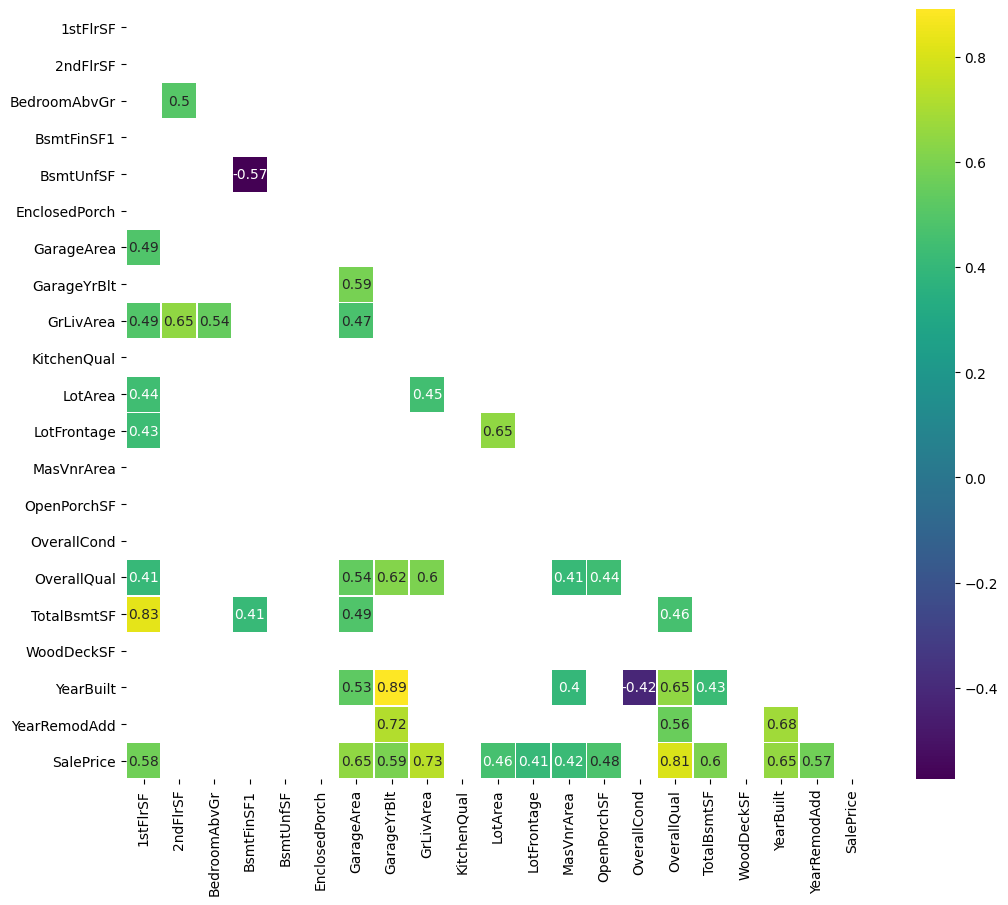



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



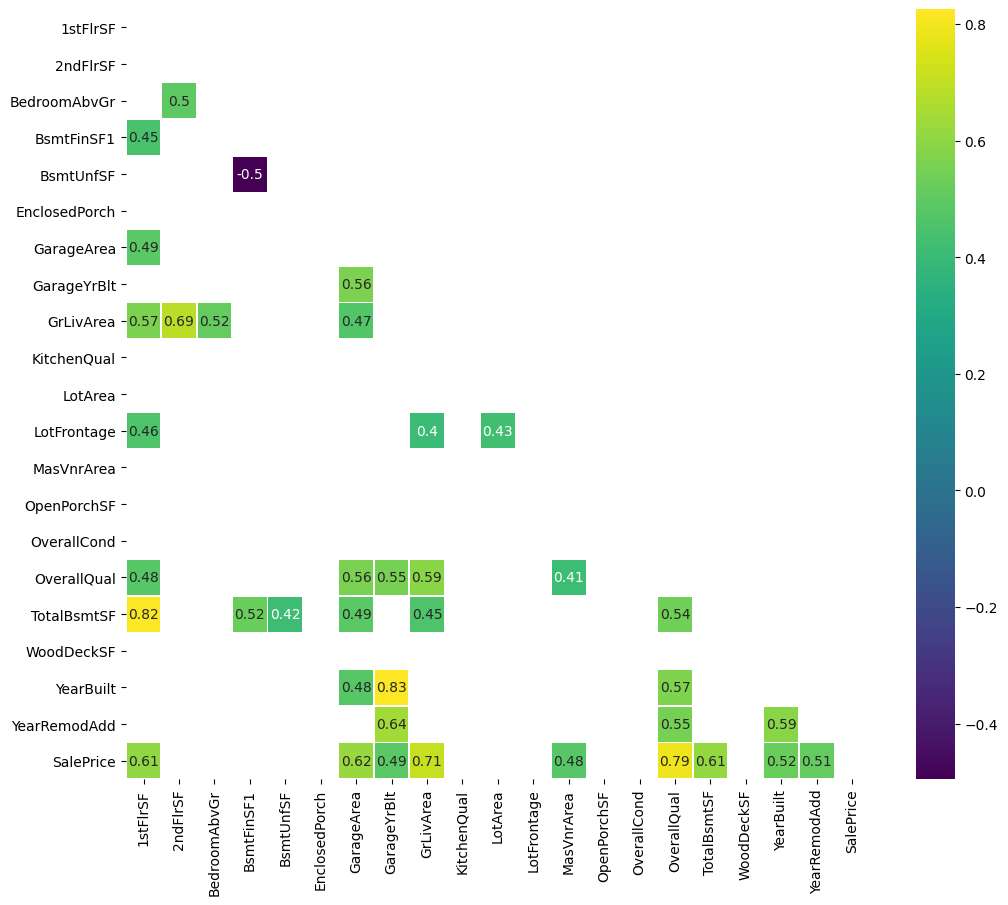



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



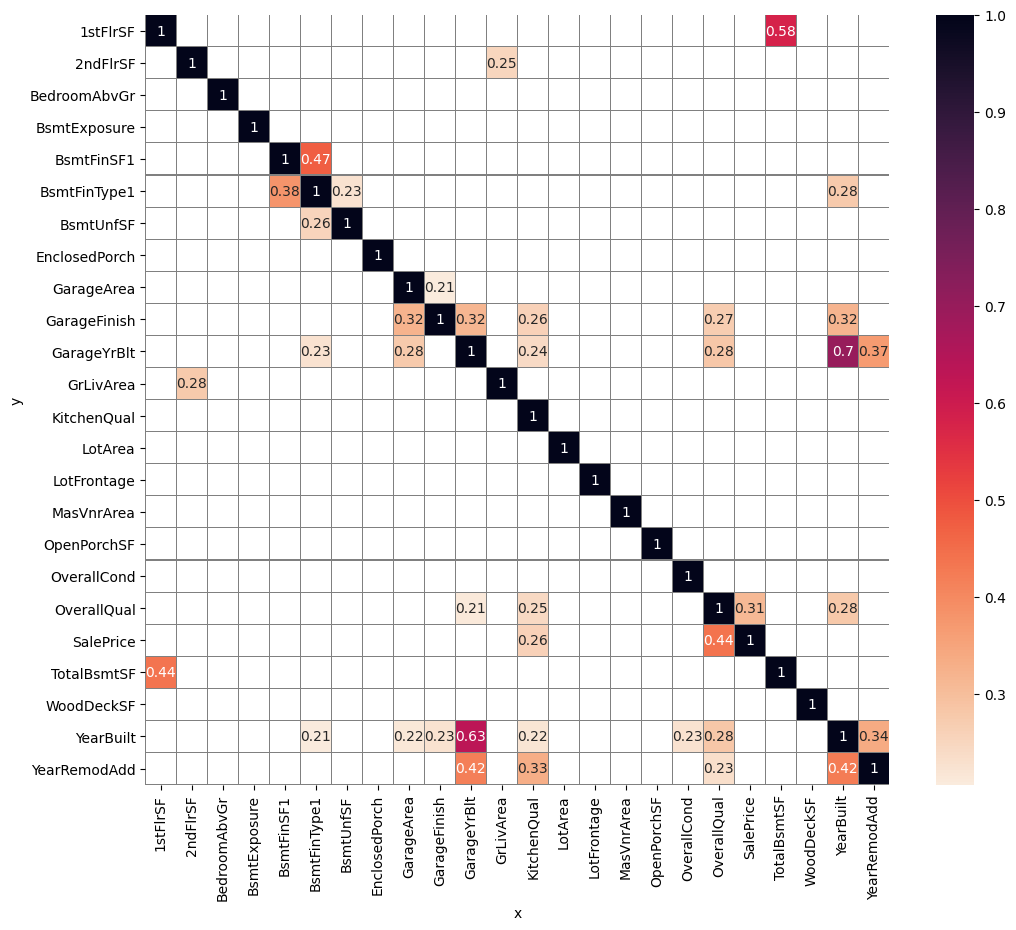

In [15]:
%matplotlib inline

DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

### Observations
 
* **GrLivingArea** and **OverallQual** have the highest correlation with SalePrice; both of them are complete in the dataset.

---

## Handling Missing Data

### 1. Check the distribution and shape of a variable with missing data.

In [14]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 2. Get a list of all the column titles to be used in spreadsheet

In [11]:
column_titles = df.columns.tolist()
print(column_titles)

['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice']


In [9]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

### 3. Assessing missing data levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [13]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


---

## Data Cleaning Summary

* Replace empty values with placeholder n/a, because are houses with only one floor. ('2ndFlrSF')



In [27]:
df['2ndFlrSF'] = df['2ndFlrSF'].fillna('n/a')

import os
try:
  os.makedirs(name='outputs/datasets/collection') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

df.to_csv(f"outputs/datasets/collection/house_price_records.csv",index=False)

* Drop - ('BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF')

* Create a separate DataFrame applying this imputation approach to the selected variables.

In [28]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [29]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data


* There are 8 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


## Drop Variables

In [30]:
variables_method = ['BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF']

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 8 variables to drop 

['BedroomAbvGr', 'BsmtFinType1', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF']


In [31]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

## Apply the transformation to all data.

In [32]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

In [33]:
EvaluateMissingData(TrainSet)


,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push cleaned data to Repo

For good practice we save files generated for the project in a different folder.


In [35]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

## Train Set

In [36]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [37]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)